# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training. It is better if don't even import it.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [1]:
import torch
import torchvision
from evaluate import evaluate

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 169M/169M [00:02<00:00, 57.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Using device: cuda
Files already downloaded and verified


### Example of a simple CNN model

In [ ]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [ ]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.5927
Epoch [2/10], Loss: 4.5898
Epoch [3/10], Loss: 4.5984
Epoch [4/10], Loss: 4.5864
Epoch [5/10], Loss: 4.5467
Epoch [6/10], Loss: 4.5617
Epoch [7/10], Loss: 4.4748
Epoch [8/10], Loss: 4.2494
Epoch [9/10], Loss: 4.2803
Epoch [10/10], Loss: 3.9809


In [ ]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 6.36%


- Res net
- bottleneck building block for deeper nets with fast training
- idenitity shortcut
- scheduler for learning rate. study if a plateau is present and in case reduce the lr at plateau
- weight initialization using kaming he initialization (works better than xavier)
- regularization using weight decay: no dropout becauase when using BN it can be avoided
- optimizer: sdg or adam

In [2]:
from typing import Optional
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from training_utils import *
import numpy as np

In [3]:
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [ ]:
transform = torchvision.transforms.ToTensor()

BATCH_SIZE = 128

# load the train dataset
train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# Split the dataset into 40k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified


I define a fit function as the one used in the tp

In [ ]:
def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler_lr: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    val_dataloader: Optional[DataLoader] = None
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        train_losses.append(train_loss)
        # Validate
        if val_dataloader is not None:
            val_loss, val_accuracy = predict(
                model=model, test_dataloader=val_dataloader, device=device, verbose=False
            )
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.0f}%"
            )
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        # LR scheduler
        if scheduler_lr is not None:
            scheduler_lr.step()

    return train_losses, val_losses, val_accuracies

The architecture I choose is a ResNet. ResNets as we have seen in class are very good network to perform image classification tasks.
The one I choose is a residual block ResNEt with a skip connection.
 Skip connection is important because it allows to have deep networks, which offer better performance, without the problem of the vanishing gradient.

I define the residual block of the ResNet.
My block is a 3-layer block with a bottleneck. I choose this structure because it allows to hava e deep network but still with manageble training times.
Each layer is made up of a convolution, a batch normalization and a ReLu used as activation function, in this order.
The three covolutions used are the following:
- 1x1 convolution layer to reduce dimensions
- 3x3 (bottleneck) convolution layer on the reduced dimension
- 1x1 convolution to restore the dimension

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_planes,
            out_channels=planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            in_channels=planes,
            out_channels=planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        # Skip connection to match dimensions when necessary
        self.skip = nn.Sequential()
        if stride > 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_planes,
                    out_channels=planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip(x)
        out = F.relu(out)
        return out

Now I write the network.

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        self.in_planes = 16  # Initial number of filters

        # First layer: 3x3 Convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Residual layers
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global Average Pooling and Fully Connected Layer
        self.linear = nn.Linear(self.in_planes, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        if out.size(2) > 1 and out.size(3) > 1:
          out = F.avg_pool2d(out, out.size(3))  # Global Average Pooling only if size is >1
        else:
          out = F.adaptive_avg_pool2d(out, (1, 1))  # fallback to adaptive avg pooling if size is too small

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

print("Model parameters: ", sum(p.numel() for p in ResNet(block=ResidualBlock, num_blocks=[12,11,10]).parameters()))



Model parameters:  986740


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
plot_loss( train_losses )


env: CUDA_LAUNCH_BLOCKING=1
ciao
Epoch 0: Train Loss=4.3782, Val Loss=4.3132, Val Accuracy=6%
Epoch 1: Train Loss=3.8137, Val Loss=3.6865, Val Accuracy=12%
Epoch 2: Train Loss=3.5255, Val Loss=3.4498, Val Accuracy=18%
Epoch 3: Train Loss=3.2766, Val Loss=3.3265, Val Accuracy=19%
Epoch 4: Train Loss=3.0513, Val Loss=3.2310, Val Accuracy=21%
Epoch 5: Train Loss=2.8521, Val Loss=3.0197, Val Accuracy=26%
Epoch 6: Train Loss=2.6604, Val Loss=2.8331, Val Accuracy=28%
Epoch 7: Train Loss=2.4892, Val Loss=2.8923, Val Accuracy=28%
Epoch 8: Train Loss=2.3442, Val Loss=2.7516, Val Accuracy=31%
Epoch 9: Train Loss=2.1924, Val Loss=2.7218, Val Accuracy=32%
Epoch 10: Train Loss=2.0816, Val Loss=2.5503, Val Accuracy=35%
Epoch 11: Train Loss=1.9625, Val Loss=2.6076, Val Accuracy=35%
Epoch 12: Train Loss=1.8510, Val Loss=2.5149, Val Accuracy=36%
Epoch 13: Train Loss=1.7639, Val Loss=2.4840, Val Accuracy=37%
Epoch 14: Train Loss=1.6715, Val Loss=2.5155, Val Accuracy=36%
Epoch 15: Train Loss=1.5934, Val 

KeyboardInterrupt: 

In [6]:
# Perform per pixel noramlization

mean = [0.5071, 0.4865, 0.4409]
std =  [0.2673, 0.2564, 0.2762]

# Define a new transform with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),    # Randomly flip images horizontally
    transforms.RandomRotation(15),       # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.ToTensor()
])

# No data augmentation for validation
val_transform = transforms.Compose([
    transforms.ToTensor()
])

# Fetch data and apply the new transformer
BATCH_SIZE = 128

# load the train dataset
augmented_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=train_transform)

base_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=val_transform)

# Split both the augmented and not augmented dataset,
# but take the training from the augmented and the validation from the not augmented

from torch.utils.data import random_split
train_dataset, _ = random_split(
    augmented_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

_, valid_dataset = random_split(
    base_dataset,
    lengths=[40000, 10000],
    generator=torch.Generator().manual_seed(42)
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Epoch 0: Train Loss=4.5341, Val Loss=4.2371, Val Accuracy=5%
Epoch 1: Train Loss=4.1085, Val Loss=3.9244, Val Accuracy=9%
Epoch 2: Train Loss=3.8339, Val Loss=3.6200, Val Accuracy=15%
Epoch 3: Train Loss=3.6370, Val Loss=3.5371, Val Accuracy=15%
Epoch 4: Train Loss=3.4863, Val Loss=3.3330, Val Accuracy=19%
Epoch 5: Train Loss=3.3254, Val Loss=3.2018, Val Accuracy=22%
Epoch 6: Train Loss=3.1787, Val Loss=3.2045, Val Accuracy=23%
Epoch 7: Train Loss=3.0417, Val Loss=3.0458, Val Accuracy=24%
Epoch 8: Train Loss=2.9036, Val Loss=2.8522, Val Accuracy=28%
Epoch 9: Train Loss=2.7661, Val Loss=2.8008, Val Accuracy=29%
Epoch 10: Train Loss=2.6613, Val Loss=2.8536, Val Accuracy=30%
Epoch 11: Train Loss=2.5652, Val Loss=2.7345, Val Accuracy=31%
Epoch 12: Train Loss=2.4693, Val Loss=2.5015, Val Accuracy=36%
Epoch 13: Train Loss=2.3911, Val Loss=2.4936, Val Accuracy=35%
Epoch 14: Train Loss=2.3186, Val Loss=2.4978, Val Accuracy=35%
Epoch 15: Train Loss=2.2581, Val Loss=2.2105, Val Accuracy=41%
Epoc

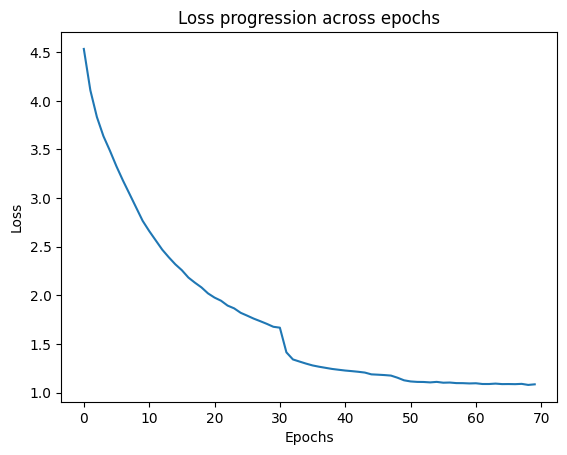

In [ ]:

model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
plot_loss( train_losses )

In [ ]:
torch.save(model.state_dict(), 'resNet_dataAug_SGD.pt')


In [7]:
import matplotlib.pyplot as plt
def plot_train_val_loss(train_losses, val_losses, ylim=None, loscale=False):
    plt.plot(train_losses, color='red', label='Training Loss')
    plt.plot(val_losses, color='blue', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.grid()
    plt.legend()
    if loscale:
        plt.yscale("log")
    plt.title("Loss progression across epochs")

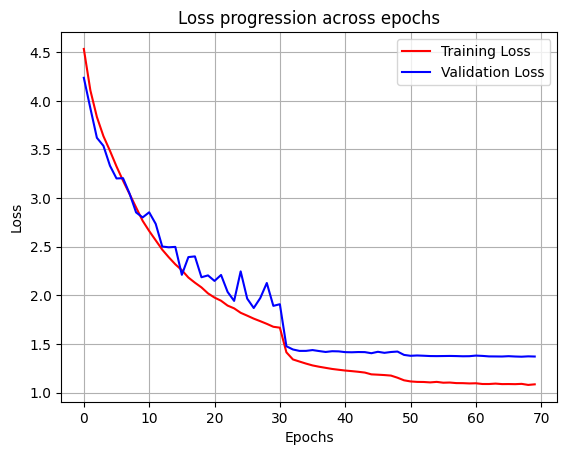

In [ ]:
plot_train_val_loss(train_losses, valid_losses)

In [22]:
def custom_lr_scheduler(current_lr, new_lr, current_accucary, prev_accuracy,
                        num_lr_reductions, patience_reductions):

    print(f"Learning rate reduced to {new_lr:.6f} (Reduction #{num_lr_reductions})")
    if current_accucary - prev_accuracy <= 2:   # Stagnant condition
        num_lr_reductions += 1
        if num_lr_reductions == patience_reductions:
            new_lr = new_lr * 100
            num_lr_reductions = 0
            print(f"Learning rate reverted to {new_lr:.6f} after {patience_reductions} reductions")
    else:
        num_lr_reductions = 0
    return new_lr, num_lr_reductions

def train_epoch_noise(model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    gradient_threshold: float = 1e-6,
    noNoiseEpoch_threshold: int = 5,
    noNoiseEpoch: list = [0],
    noise_std: float = 0.01
):
    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # Add noise component to gradient
        gradient_norm = sum(param.grad.norm().item() for param in model.parameters()) / sum(p.numel() for p in model.parameters())
        perturb_condtion1 = gradient_norm <= gradient_threshold
        perturb_codition2 = noNoiseEpoch[0] >= noNoiseEpoch_threshold

        if perturb_condtion1 and perturb_codition2:
            with torch.no_grad():
                for param in model.parameters():
                    if param.grad is not None:
                            noise = torch.randn_like(param.grad) / torch.norm(torch.randn_like(param.grad), dim=-1, keepdim=True)* noise_std
                            param.grad.add_(noise)
                # print("Noise added to gradient")
            noNoiseEpoch[0] = 0

        # we start counting the epochs without noise only when gradient is small (stagnant condition)
        if perturb_condtion1 and not perturb_codition2:
             noNoiseEpoch[0] =  noNoiseEpoch[0] + 1

        # If we exit from a small gradient condition, zero the count for epochs without noise
        # if not perturb_condtion1:
        #     noNoiseEpoch[0] = 0

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader), gradient_norm


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler_lr: Optional[torch.optim.lr_scheduler.ReduceLROnPlateau] = None,
    val_dataloader: Optional[DataLoader] = None
):
    """
    Train the model and adjust learning rate dynamically using ReduceLROnPlateau.

    If the validation loss stagnates for 3 reductions, revert the learning rate
    to its original value by multiplying by 1000.
    """
    # Keep track of losses for visualization
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Tracking learning rate changes
    num_lr_reductions = 0
    stagnant_reduction_start_lr = None
    accuracy_at_reduction = None

    noNoise_epoch = [0]
    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        # Validate
        if val_dataloader is not None:
            val_loss, val_accuracy = predict(
                model=model, test_dataloader=val_dataloader, device=device, verbose=False
            )
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(
                f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.0f}%"
            )
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")

        if scheduler_lr is not None:
            current_lr = optimizer.param_groups[0]['lr']
            scheduler_lr.step(metrics=val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < current_lr:
              print(f"Learning rate reduced to {new_lr:.6f}")

    return train_losses, val_losses, val_accuracies

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradien Norm: 24.553634233307093
Epoch 0: Train Loss=4.4412, Val Loss=4.1814, Val Accuracy=6%
Gradien Norm: 32.26240393705666
Epoch 1: Train Loss=4.0260, Val Loss=3.8791, Val Accuracy=10%
Gradien Norm: 37.83619228191674
Epoch 2: Train Loss=3.8143, Val Loss=3.6994, Val Accuracy=13%
Gradien Norm: 39.625462325289845
Epoch 3: Train Loss=3.6332, Val Loss=3.5481, Val Accuracy=16%
Gradien Norm: 35.893998426385224
Epoch 4: Train Loss=3.4715, Val Loss=3.3637, Val Accuracy=19%
Gradien Norm: 43.02030966989696
Epoch 5: Train Loss=3.3231, Val Loss=3.1701, Val Accuracy=22%
Gradien Norm: 38.67332382686436
Epoch 6: Train Loss=3.1820, Val Loss=3.3029, Val Accuracy=21%
Gradien Norm: 38.40576772112399
Epoch 7: Train Loss=3.0443, Val Loss=3.1670, Val Accuracy=23%
Gradien Norm: 43.256425350904465
Epoch 8: Train Loss=2.9100, Val Loss=2.8819, Val Accuracy=28%
Gradien Norm: 48.00921353884041
Epoch 9: Train Loss=2.7770, Val Loss=2.8160, Val Accuracy=28%
Gradien Norm: 44.30502455867827
Epoch 10: Train Loss=2.67

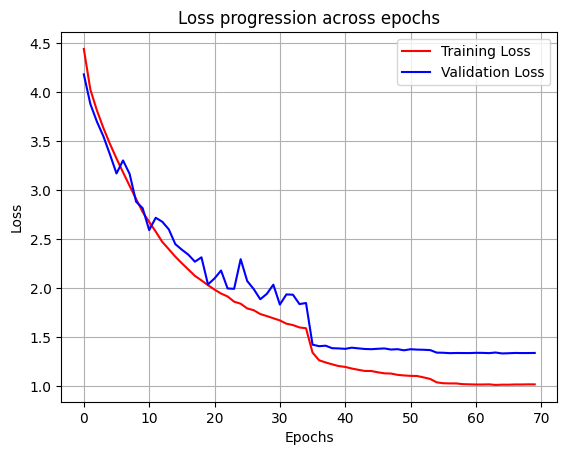

In [14]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr,
        gradient_threshold= 1e-4,
        noNoiseEpochs_threshold= 3,
        std_noise= 0.01
    )
torch.save(model.state_dict(), 'resNet_dataAug_noiseSDG.pt')
plot_train_val_loss(train_losses, valid_losses)

Epoch 0: Train Loss=4.6907, Val Loss=4.5988, Val Accuracy=1%
Epoch 1: Train Loss=4.5746, Val Loss=4.5216, Val Accuracy=2%
Epoch 2: Train Loss=4.2283, Val Loss=4.1162, Val Accuracy=6%
Epoch 3: Train Loss=3.9316, Val Loss=3.8302, Val Accuracy=10%
Epoch 4: Train Loss=3.6728, Val Loss=3.7518, Val Accuracy=13%
Epoch 5: Train Loss=3.4671, Val Loss=3.4054, Val Accuracy=18%
Epoch 6: Train Loss=3.2693, Val Loss=3.4713, Val Accuracy=18%
Epoch 7: Train Loss=3.0985, Val Loss=3.3117, Val Accuracy=20%
Epoch 8: Train Loss=2.9601, Val Loss=3.2858, Val Accuracy=22%
Epoch 9: Train Loss=2.8630, Val Loss=2.8824, Val Accuracy=28%
Epoch 10: Train Loss=2.7774, Val Loss=2.8851, Val Accuracy=28%
Epoch 11: Train Loss=2.7258, Val Loss=3.1945, Val Accuracy=25%
Epoch 12: Train Loss=2.6786, Val Loss=2.7952, Val Accuracy=30%
Epoch 13: Train Loss=2.6261, Val Loss=2.7978, Val Accuracy=31%
Epoch 14: Train Loss=2.5856, Val Loss=2.7322, Val Accuracy=32%
Epoch 15: Train Loss=2.5386, Val Loss=2.8670, Val Accuracy=30%
Epoch

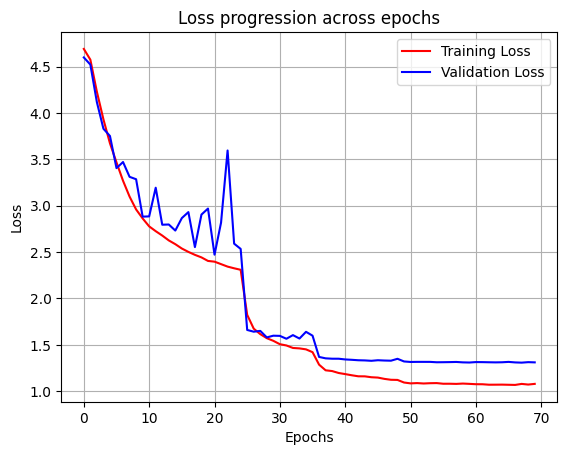

In [24]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
torch.save(model.state_dict(), 'resNet_dataAug_noiseSDG.pt')
plot_train_val_loss(train_losses, valid_losses)

In [ ]:
model = ResNet(block=ResidualBlock, num_blocks=[12, 11, 10]).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9, nesterov=True)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3, verbose=True)

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 70,
        device = DEVICE,
        val_dataloader = valid_dataloader,
        scheduler_lr = scheduler_lr
    )
torch.save(model.state_dict(), 'resNet_dataAug_nesterov_0p5SchedulerFactor.pt')
plot_train_val_loss(train_losses, valid_losses)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss=4.4510, Val Loss=4.1382, Val Accuracy=5%
Epoch 1: Train Loss=3.9764, Val Loss=3.8233, Val Accuracy=11%
Epoch 2: Train Loss=3.6573, Val Loss=3.5676, Val Accuracy=15%
Epoch 3: Train Loss=3.3296, Val Loss=3.5266, Val Accuracy=19%
Epoch 4: Train Loss=3.0506, Val Loss=3.4102, Val Accuracy=21%
Epoch 5: Train Loss=2.8271, Val Loss=3.2591, Val Accuracy=23%
Epoch 6: Train Loss=2.6607, Val Loss=3.2051, Val Accuracy=26%
Epoch 7: Train Loss=2.5509, Val Loss=2.6076, Val Accuracy=33%
Epoch 8: Train Loss=2.4656, Val Loss=3.2850, Val Accuracy=25%
Epoch 9: Train Loss=2.3907, Val Loss=2.8603, Val Accuracy=29%
Epoch 10: Train Loss=2.3485, Val Loss=3.1880, Val Accuracy=26%
Epoch 11: Train Loss=2.3056, Val Loss=2.6365, Val Accuracy=34%
Learning rate reduced to 0.050000
Epoch 12: Train Loss=2.0066, Val Loss=2.0772, Val Accuracy=45%
Epoch 13: Train Loss=1.9696, Val Loss=2.7886, Val Accuracy=36%
Epoch 14: Train Loss=1.9585, Val Loss=2.1597, Val Accuracy=43%
Epoch 15: Train Loss=1.9402, Val

- Try to change regularization parameter
- Try SGD optmizier with momentum
- Remove the per pixel mean before feeding the images into the network
- Retry the bottleneck architecture.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=val_transform)

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


Files already downloaded and verified


In [ ]:
evaluate(loaded_model)

The model has 986740 parameters
Accuracy on the test set: 61.8%
